In [394]:
# The goal of this nb is to create a ML model to predict the expected payout (for the insurance company) given an individual and their subsequent characteristics such as age, sex, smoking, etc. 

# ExpAmt fields – these values represent the expected claim amounts for the policy year based upon certain mortality tables (such as the 2015 vbt, for example).
    # The values depend upon various factors such as issue age, sex, smoker/non-smoker, and duration.
    # For example, suppose we had a policy issued on a 20-year-old male non-smoker that is now in its 10th policy year (duration = 10, and the insured is now 30 years old).
    # According to the 2015 vbt table, the expected death rate for such a person is 0.44 per 1000; said differently, you could say that such an individual has a 0.44/1000 = 0.00044 probability of dying that year.
    # If the policy were for 500,000, then our expected claim amount for the policy year would be 500,000 * 0.44 / 1000 = 220.
    # As you might expect, older individuals will typically have a higher probability of dying and thus higher expected claim amounts for the same policy size.
    # Similarly, different smoker status and/or sex will affect the expected claim amounts.

In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# Bring in Data


# Path for PC --- Uncomment out depending on device
# df0 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2020.csv')
# df1 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2021.csv')
# df2 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2022.csv')
# df3 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2023.csv')


# Path for Laptop
df0 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2020.csv')
df1 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2021.csv')
df2 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2022.csv')
df3 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2023.csv')


data = pd.concat([df0,df1,df2,df3], axis=0,ignore_index=True,)

data = data.drop_duplicates()

C:\Users\oakle\AppData\Local\Temp\ipykernel_24544\4030374115.py:12: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2020.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_24544\4030374115.py:13: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2021.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_24544\4030374115.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2022.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_24544\4030374115.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv(r'C:\Users\oakle\Documents

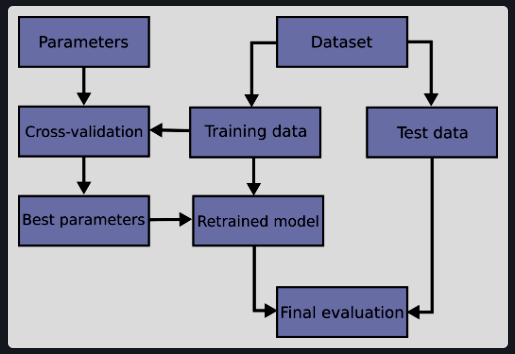

In [514]:
# ----------------- ----- Data Preprocesing -----------------------

In [881]:
# Define X variable
df = data[['CvgSexCode',
        # 'CvgIssueAge',
        'Duration',
        'AttainedAge',
        'UWClass',
        'SubstandardIndicator',
        '2015vbtExpAmt',
        '2015vbtExpNum',
        'MortExposureAmt',
        # 'MortExposureNum',
        'MortDecAmt'
        ]]

# Remove duplicates
df = df.drop_duplicates()

# Remove Empty Values
df = df.dropna()



# Print X
df

,CvgSexCode,Duration,AttainedAge,UWClass,SubstandardIndicator,2015vbtExpAmt,2015vbtExpNum,MortExposureAmt,MortDecAmt
0,M,20,52,ST,N,483.000000,0.0032,100000.000000,0.0
1,F,20,72,SN,N,53.895833,0.0008,5416.666667,0.0
2,F,20,71,SN,N,125.091667,0.0014,14166.666670,0.0
3,M,20,47,ST,N,54.450000,0.0008,16500.000000,0.0
4,M,20,71,ST,N,255.403333,0.0026,8041.666667,0.0
...,...,...,...,...,...,...,...,...,...
3324010,M,15,18,SN,N,38.500000,0.0007,50000.000000,0.0
3324011,M,15,20,SN,N,43.500000,0.0008,50000.000000,0.0
3324012,F,14,61,PN,N,285.083333,0.0028,91666.666670,0.0
3324014,M,15,31,SN,N,182.000000,0.0009,200000.000000,0.0


In [882]:
df = df[df['SubstandardIndicator'] == 'N']

# Create a 'PayoutOccurred' binary column (1 for payout, 0 for no payout)
df['PayoutOccurred'] = df['MortDecAmt'].apply(lambda x: 1 if x > 0 else 0)

C:\Users\oakle\AppData\Local\Temp\ipykernel_27372\4234322793.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PayoutOccurred'] = df['MortDecAmt'].apply(lambda x: 1 if x > 0 else 0)


In [883]:
df['UWClass'].value_counts()

UWClass
SN    680011
SS    294062
PN    240291
SP    177577
ST    151946
PP    128462
PT     24967
PS       334
Name: count, dtype: int64

In [884]:
df.reset_index(inplace=True,drop=True)

# # Define how UWClass will map to numerical values
# map = {'SN': 1,
#        'PN': 2,
#        'SS': 3,
#        'SP': 4,
#        'ST': 5,
#        'PP': 6,
#        'PT': 7,
#        'PS': 8
#         }

# Convert sex code to binary
df['IsMale'] = np.where(df['CvgSexCode'] == 'M', 1, 0)

# Convert UnderWritingClass to numeric classes
UWClass_dummies = pd.get_dummies(data=df['UWClass'],dtype=int)
UWClass_dummies

# Remove old columns that have been converted to binary values or removed
df = df.drop(columns=['CvgSexCode','SubstandardIndicator','UWClass'])
df = pd.concat([df,UWClass_dummies],axis =1)
df = df.reindex(['IsMale','Duration','AttainedAge','MortExposureAmt','2015vbtExpAmt','2015vbtExpNum','PN','PP','PS','PT','SN','SP','SS','ST','MortDecAmt','PayoutOccurred'],axis =1)

df



C:\Users\oakle\AppData\Local\Temp\ipykernel_27372\1503544358.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsMale'] = np.where(df['CvgSexCode'] == 'M', 1, 0)


,IsMale,Duration,AttainedAge,MortExposureAmt,2015vbtExpAmt,2015vbtExpNum,PN,PP,PS,PT,SN,SP,SS,ST,MortDecAmt,PayoutOccurred
0,1,20,52,100000.000000,483.000000,0.0032,0,0,0,0,0,0,0,1,0.0,0
1,0,20,72,5416.666667,53.895833,0.0008,0,0,0,0,1,0,0,0,0.0,0
2,0,20,71,14166.666670,125.091667,0.0014,0,0,0,0,1,0,0,0,0.0,0
3,1,20,47,16500.000000,54.450000,0.0008,0,0,0,0,0,0,0,1,0.0,0
4,1,20,71,8041.666667,255.403333,0.0026,0,0,0,0,0,0,0,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697645,1,15,18,50000.000000,38.500000,0.0007,0,0,0,0,1,0,0,0,0.0,0
1697646,1,15,20,50000.000000,43.500000,0.0008,0,0,0,0,1,0,0,0,0.0,0
1697647,0,14,61,91666.666670,285.083333,0.0028,1,0,0,0,0,0,0,0,0.0,0
1697648,1,15,31,200000.000000,182.000000,0.0009,0,0,0,0,1,0,0,0,0.0,0


In [875]:
df['PayoutOccurred'].value_counts()
# print(f'Data payout ratio: {df['PayoutOccurred'].value_counts()[0]/df['PayoutOccurred'].value_counts()[1]}')

Series([], Name: count, dtype: int64)

In [520]:
# Group age into groups of 5

# Define the age intervals
bins = list(range(0, 65, 5))  # Up to 60+ group

# Create group labels, assigning the highest group number to the 60+ group
num_groups = len(bins) - 1
labels = list(range(num_groups))

# Categorize ages using pd.cut
df['AttainedAge'] = pd.cut(df['AttainedAge'], bins=bins, labels=labels, right=False)

# Display the DataFrame with categorized age groups
df

,Duration,AttainedAge,UWClass,2015vbtExpAmt,2015vbtExpNum,MortExposureAmt,MortDecAmt,PayoutOccurred,IsMale
0,20,10,5,483.000000,0.0032,100000.000000,0.0,0,1
1,20,NaN,1,53.895833,0.0008,5416.666667,0.0,0,0
2,20,NaN,1,125.091667,0.0014,14166.666670,0.0,0,0
3,20,9,5,54.450000,0.0008,16500.000000,0.0,0,1
4,20,NaN,5,255.403333,0.0026,8041.666667,0.0,0,1
...,...,...,...,...,...,...,...,...,...
1697645,15,3,1,38.500000,0.0007,50000.000000,0.0,0,1
1697646,15,4,1,43.500000,0.0008,50000.000000,0.0,0,1
1697647,14,NaN,2,285.083333,0.0028,91666.666670,0.0,0,0
1697648,15,6,1,182.000000,0.0009,200000.000000,0.0,0,1


In [521]:
# ------------------- FROM THIS POINT ON ALL TRAIN AND TEST DATA MUST BE SEPARATE. --------------------------------
# ---------------- THERE SHOULD BE NO COMPUTATIONS DONE ON THE DATA BEFORE THIS POINT ----------------------------------


# split data into classification and regression data sets

classification_df, regression_df = train_test_split(df,test_size=.3,random_state=42,stratify=df['PayoutOccurred'])
regression_df = regression_df.reset_index(drop=True)
classification_df = classification_df.reset_index(drop=True)
regression_df

,Duration,AttainedAge,UWClass,2015vbtExpAmt,2015vbtExpNum,MortExposureAmt,MortDecAmt,PayoutOccurred,IsMale
0,19,7,1,46.410320,0.0018,50446.00000,0.0,0,1
1,2,3,1,36.750000,0.0012,75000.00000,0.0,0,1
2,1,5,1,12.800000,0.0002,80000.00000,0.0,0,1
3,11,7,7,327.500000,0.0013,250000.00000,0.0,0,1
4,15,NaN,5,687.012931,0.0256,26752.84000,0.0,0,1
...,...,...,...,...,...,...,...,...,...
509290,5,11,2,181.820595,0.0017,102723.50000,0.0,0,1
509291,10,7,5,21.271153,0.0008,23120.81836,0.0,0,0
509292,32,10,3,49.757314,0.0038,25648.10000,0.0,0,0
509293,13,5,1,44.562514,0.0008,51221.28000,0.0,0,1


In [522]:

# Split classification data
train_data,test_data = train_test_split(classification_df, test_size=0.4, random_state=42,stratify=classification_df['PayoutOccurred'])

# train_data = pd.concat([X_train,y_train])
# test_data = pd.concat([X_test,y_test])

# Aggregate train data
aggregated_train = train_data.groupby(['IsMale', 
                                       'UWClass', 
                                    #    'CvgIssueAge', 
                                       'AttainedAge', 
                                       'Duration',
                                    #    '2015vbtExpNum'
                                       ]).agg(
    
    TotalCount=('PayoutOccurred', 'count'),
    AvgPayoutAmt=('MortExposureAmt', 'mean'),
    # AvgDeathRisk=('MortExposureNum', 'mean'),
    AvgExpDeathRisk=('2015vbtExpNum','mean'),
    PayoutOccurrenceRate=('PayoutOccurred', 'mean')
).reset_index()

# Aggregate test data
aggregated_test = test_data.groupby(['IsMale', 
                                     'UWClass', 
                                    #  'CvgIssueAge', 
                                     'AttainedAge', 
                                     'Duration',
                                    #  '2015vbtExpNum'
                                     ]).agg(
    TotalCount=('PayoutOccurred', 'count'),
    AvgPayoutAmt=('MortExposureAmt', 'mean'),
    # AvgDeathRisk=('MortExposureNum', 'mean'),
    AvgExpDeathRisk=('2015vbtExpNum','mean'),
    PayoutOccurrenceRate=('PayoutOccurred', 'mean')
).reset_index()


C:\Users\oakle\AppData\Local\Temp\ipykernel_27372\4081191579.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_train = train_data.groupby(['IsMale',
C:\Users\oakle\AppData\Local\Temp\ipykernel_27372\4081191579.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_test = test_data.groupby(['IsMale',


In [523]:
aggregated_train = aggregated_train.fillna(0)
aggregated_test = aggregated_test.fillna(0)
aggregated_train

,IsMale,UWClass,AttainedAge,Duration,TotalCount,AvgPayoutAmt,AvgExpDeathRisk,PayoutOccurrenceRate
0,0,1,0,1,470,450547.303092,0.001174,0.0
1,0,1,0,2,447,409819.627781,0.000443,0.0
2,0,1,0,3,418,493670.197515,0.000000,0.0
3,0,1,0,4,341,534117.230445,0.000000,0.0
4,0,1,0,5,198,690347.909058,0.000000,0.0
...,...,...,...,...,...,...,...,...
7867,1,8,11,37,0,0.000000,0.000000,0.0
7868,1,8,11,38,0,0.000000,0.000000,0.0
7869,1,8,11,39,0,0.000000,0.000000,0.0
7870,1,8,11,40,0,0.000000,0.000000,0.0


In [524]:
# Scale all continuous variables to be between 0-1
from sklearn.preprocessing import minmax_scale

aggregated_train = minmax_scale(X=aggregated_train)
aggregated_train = pd.DataFrame(aggregated_train)

new_column_names = ['IsMale', 'UWClass', 'AttainedAge', 'Duration', '2015vbtExpNum',
                    'TotalCount', 'AvgPayoutAmt', 'PayoutOccurrenceRate']
aggregated_train.columns = new_column_names
aggregated_train

,IsMale,UWClass,AttainedAge,Duration,2015vbtExpNum,TotalCount,AvgPayoutAmt,PayoutOccurrenceRate
0,0.0,0.0,0.0,0.000,0.447619,0.288517,0.120654,0.0
1,0.0,0.0,0.0,0.025,0.425714,0.262436,0.045475,0.0
2,0.0,0.0,0.0,0.050,0.398095,0.316131,0.000000,0.0
3,0.0,0.0,0.0,0.075,0.324762,0.342032,0.000000,0.0
4,0.0,0.0,0.0,0.100,0.188571,0.442078,0.000000,0.0
...,...,...,...,...,...,...,...,...
7867,1.0,1.0,1.0,0.900,0.000000,0.000000,0.000000,0.0
7868,1.0,1.0,1.0,0.925,0.000000,0.000000,0.000000,0.0
7869,1.0,1.0,1.0,0.950,0.000000,0.000000,0.000000,0.0
7870,1.0,1.0,1.0,0.975,0.000000,0.000000,0.000000,0.0


In [525]:
# Scale all continuous variables to be between 0-1
aggregated_test = minmax_scale(X=aggregated_test)
aggregated_test = pd.DataFrame(aggregated_test)

new_column_names = ['IsMale', 'UWClass', 'AttainedAge', 'Duration', '2015vbtExpNum',
                    'TotalCount', 'AvgPayoutAmt', 'PayoutOccurrenceRate']

aggregated_test.columns = new_column_names
aggregated_test

,IsMale,UWClass,AttainedAge,Duration,2015vbtExpNum,TotalCount,AvgPayoutAmt,PayoutOccurrenceRate
0,0.0,0.0,0.0,0.000,0.461111,0.347490,0.091041,0.000000
1,0.0,0.0,0.0,0.025,0.445833,0.326160,0.034252,0.000000
2,0.0,0.0,0.0,0.050,0.366667,0.361138,0.000000,0.015152
3,0.0,0.0,0.0,0.075,0.284722,0.387798,0.000000,0.000000
4,0.0,0.0,0.0,0.100,0.205556,0.415521,0.000000,0.000000
...,...,...,...,...,...,...,...,...
7867,1.0,1.0,1.0,0.900,0.000000,0.000000,0.000000,0.000000
7868,1.0,1.0,1.0,0.925,0.000000,0.000000,0.000000,0.000000
7869,1.0,1.0,1.0,0.950,0.000000,0.000000,0.000000,0.000000
7870,1.0,1.0,1.0,0.975,0.000000,0.000000,0.000000,0.000000


In [526]:
# Define input and output variables Train

X_train = aggregated_train[['IsMale', 
                   'UWClass', 
                  #  'CvgIssueAge', 
                   'AttainedAge', 
                   'Duration',
                   'TotalCount',
                   'AvgPayoutAmt',
                  #  'AvgDeathRisk',  
                  #  'AvgExpDeathRisk'
                #    'PayoutOccurrenceRate'
                   ]]

# Binary target: 1 if there was a payout, 0 otherwise
y_train= (aggregated_train['PayoutOccurrenceRate'] > 0).astype(int)  


# Define input and output variables Test
X_test = aggregated_test[['IsMale', 
                   'UWClass', 
                  #  'CvgIssueAge', 
                   'AttainedAge', 
                   'Duration',
                   'TotalCount',
                   'AvgPayoutAmt',
                  #  'AvgDeathRisk',
                  #  'AvgExpDeathRisk'
                  #  'PayoutOccurrenceRate'
                   ]]

y_test= (aggregated_test['PayoutOccurrenceRate'] > 0).astype(int)  # Binary target: 1 if there was a payout, 0 otherwise



In [527]:
X_train

,IsMale,UWClass,AttainedAge,Duration,TotalCount,AvgPayoutAmt
0,0.0,0.0,0.0,0.000,0.288517,0.120654
1,0.0,0.0,0.0,0.025,0.262436,0.045475
2,0.0,0.0,0.0,0.050,0.316131,0.000000
3,0.0,0.0,0.0,0.075,0.342032,0.000000
4,0.0,0.0,0.0,0.100,0.442078,0.000000
...,...,...,...,...,...,...
7867,1.0,1.0,1.0,0.900,0.000000,0.000000
7868,1.0,1.0,1.0,0.925,0.000000,0.000000
7869,1.0,1.0,1.0,0.950,0.000000,0.000000
7870,1.0,1.0,1.0,0.975,0.000000,0.000000


In [528]:
# sns.displot(kind='kde',
#            data=tempAgePlot,
#            x= 'AttainedAge',
#            y='MortDecAmt'
#            )
# plt.show()

In [529]:
# Checking for differences in the train and test data

print(f'Y_train Value Counts: {y_train.value_counts()}')
print()
print(f'Y_test Value Counts: {y_test.value_counts()}')
print()
print(f'Training data payout ratio: {y_train.value_counts()[0]/y_train.value_counts()[1]}')
print(f'Test data payout ratio : {y_test.value_counts()[0]/y_test.value_counts()[1]}')

Y_train Value Counts: PayoutOccurrenceRate
0    6880
1     992
Name: count, dtype: int64

Y_test Value Counts: PayoutOccurrenceRate
0    7074
1     798
Name: count, dtype: int64

Training data payout ratio: 6.935483870967742
Test data payout ratio : 8.864661654135338


In [530]:
# Use SMOTE to synthetically add more payout data points to even out the classes

from imblearn.over_sampling import SMOTE


# Apply SMOTE to the training set only to avoid data leakage
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Checking the distribution after SMOTE
print("After SMOTE:")
print(f'Y_train Value Counts: {y_train_resampled.value_counts()}')
print()
print(f'Training data payout ratio: {y_train_resampled.value_counts()[0]/y_train_resampled.value_counts()[1]}')

X_train= X_train_resampled
y_train= y_train_resampled
X_train

After SMOTE:
Y_train Value Counts: PayoutOccurrenceRate
0    6880
1    6880
Name: count, dtype: int64

Training data payout ratio: 1.0


,IsMale,UWClass,AttainedAge,Duration,TotalCount,AvgPayoutAmt
0,0.0,0.000000,0.000000,0.000000,0.288517,0.120654
1,0.0,0.000000,0.000000,0.025000,0.262436,0.045475
2,0.0,0.000000,0.000000,0.050000,0.316131,0.000000
3,0.0,0.000000,0.000000,0.075000,0.342032,0.000000
4,0.0,0.000000,0.000000,0.100000,0.442078,0.000000
...,...,...,...,...,...,...
13755,0.0,0.285714,0.514489,0.725000,0.068700,0.135516
13756,1.0,0.000000,0.698478,0.050000,0.594009,0.067740
13757,0.0,0.000000,0.818182,0.168744,0.162643,0.100263
13758,1.0,0.714286,0.830568,0.857968,0.049757,0.447943


In [531]:
#---------------------------------------------- Create Multicollinearity Matrix for 2015_Norm Variable ---------------------------------

# If num > .90 , Column x Row are collinear
X_train = pd.DataFrame(X_train)

# Put Y infront of X variables
Xy_collin = pd.concat([y_train, X_train.drop(columns=['IsMale'],axis =1)],axis = 1)

# Define collin as standard scaler - [See Sklearn docs for more info]
collin = StandardScaler()

# Fit collin
collin_fit = collin.fit(Xy_collin)

# Convert collin fit back to pd.Dataframe
df_collin = pd.DataFrame(collin_fit.transform(Xy_collin))
df_collin.columns = Xy_collin.columns
df_collin.index = Xy_collin.index

corr_m = df_collin.corr(method='pearson')

corr_m_abs = corr_m.abs()
corr_m_upper = corr_m_abs.where(
    np.triu(np.ones(corr_m_abs.shape), k=1).astype(bool))

corr_m_upper

# Notes:
# Take a look at using Variance inflation factor or CP and CP Plot

,PayoutOccurrenceRate,UWClass,AttainedAge,Duration,TotalCount,AvgPayoutAmt
PayoutOccurrenceRate,NaN,0.386074,0.521104,0.200209,0.466337,0.607056
UWClass,NaN,NaN,0.092130,0.129773,0.347719,0.085479
AttainedAge,NaN,NaN,NaN,0.032337,0.267199,0.582513
Duration,NaN,NaN,NaN,NaN,0.496794,0.149218
TotalCount,NaN,NaN,NaN,NaN,NaN,0.061388
AvgPayoutAmt,NaN,NaN,NaN,NaN,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

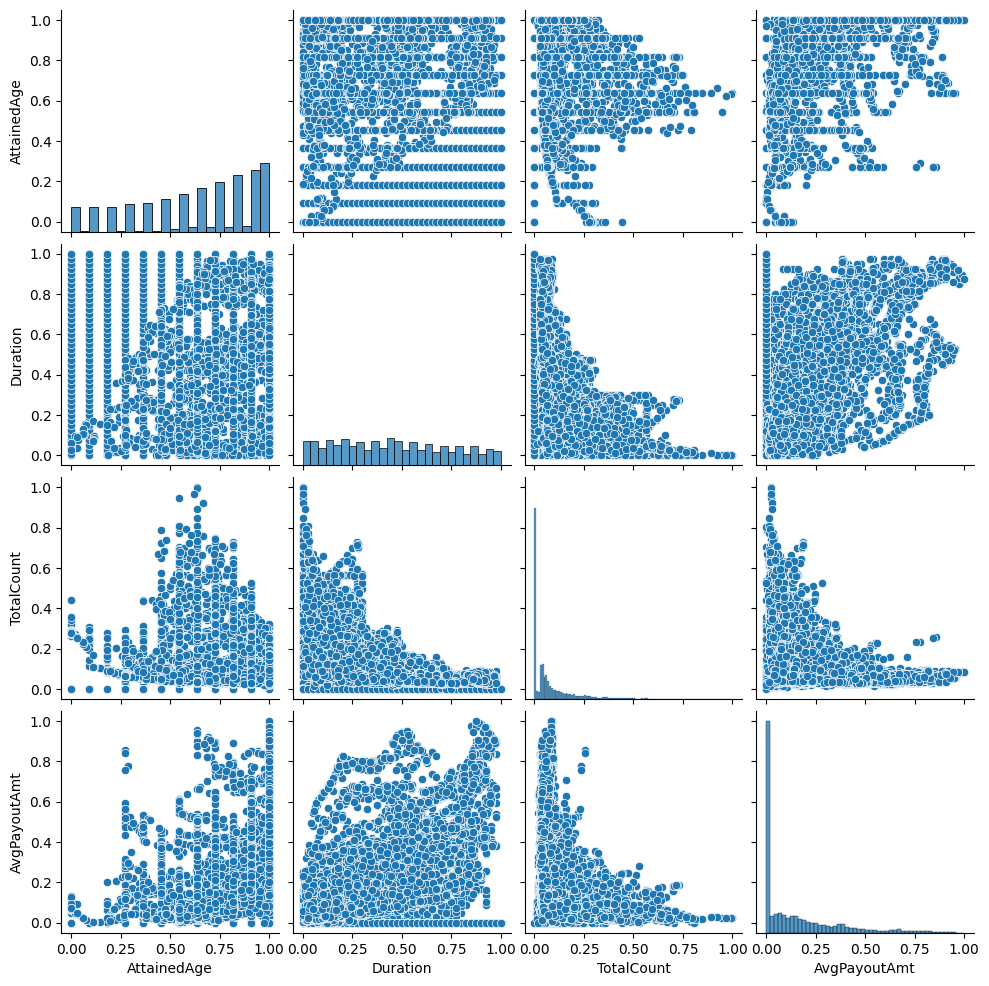

In [532]:
# Create Pairplot to check for weird Data (Purely Qualitative)
# Simply checking for any abnomalities and outliers

sns.pairplot(data=(X_train.drop(columns=['IsMale','UWClass'])))
plt.show

In [626]:
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

# Define the Plot and regress method
def plot_and_measure_regression(model_name :str , y_pred, y_true):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    y_pred_sorted = np.sort(y_pred, axis=0)
    y_true_sorted = np.sort(y_true, axis=0)

    plt.figure
    plt.plot(y_pred_sorted, color = 'Blue', label = 'Predicted')
    plt.plot(y_true_sorted, color = 'Orange', label = 'Expected')
    plt.title(f'{model_name} Regression Chart')
    plt.xlabel('Sorted Index (meaningless)')
    plt.xlim(660000,(len(y_pred) + 250))
    plt.legend()
    plt.ylabel(f'Payout amount ($\'s)')
    plt.show()


# Define classification plot method
def plot_and_measure_classification(model_name :str , y_pred, y_true):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    y_true_sorted = np.sort(y_true, axis=0)
    y_pred_sorted = np.sort(y_pred, axis=0)

    plt.figure
    plt.hist(x=y_pred,label='Predicted')
    plt.hist(x=y_true,label='True')
    plt.legend()
    plt.title('Classification Graph')
    plt.show() 


# Define Expected vs Predicted graph function
def exp_vs_pred(model_name :str, y_pred, y_true):

    plt.scatter(x= y_true, y= y_pred, color = 'Blue')
    plt.axline(xy1=(0,0), slope= 1, color = 'Orange',label = 'Ideal Line')
    plt.title(f'{model_name} Expected vs Predicted')
    plt.legend()
    plt.xlabel(f'y_true')
    plt.ylabel(f'y_pred')
    plt.show()


# Define function to print MSE and R2 values
def print_scores(y_pred, y_true, model:str):
    
    MSE = mean_squared_error(y_true= y_true,
                              y_pred=y_pred
                              )
    R2 = r2_score(y_true= y_true,
                   y_pred=y_pred)
    
    print(f'{model} R2 Score = {R2}')
    print(f'{model} MSE Score = {MSE}')

# Define function to print F1 and PR-AUC values
def print_class_scores(y_pred, y_true, model:str):
    
    F1 = f1_score(y_true= y_true, 
                  y_pred=y_pred
                              )
    aps = average_precision_score(y_true= y_true,
                  y_score=y_pred)
    
    print(f'{model} F1 Score = {F1}')
    print(f'{model} Precision Recall-AUC Score = {aps}')


# Define function to return F1 and PR-AUC values
def get_class_scores(y_pred, y_true):
    
    F1 = f1_score(y_true= y_true, 
                  y_pred=y_pred
                              )
    aps = average_precision_score(y_true= y_true,
                  y_score=y_pred)
    
    return {
        'F1': F1,
        'PR-AUC': aps
        }


# Define function to return MSE and R2 values
def get_scores(y_pred, y_true):
    
    MSE = mean_squared_error(y_true= y_true,
                              y_pred=y_pred
                              )
    
    R2 = r2_score(y_true= y_true,
                   y_pred=y_pred)
    
    return {'R2':R2,
            'MSE': MSE
            }

In [534]:
# End of Pre Processing - Now Testing Model Types

# Goal: 

# To have a two part model. 
# First predict whether or not a payout will occur 
# then assign the value of the non-zero output as the same as the policy ammount

In [535]:
# -------------------- Part 1: Classification (Death or no Death) --------------

# Convert y_train to dataframe for compatability
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


from sklearn.metrics import confusion_matrix


c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gradient Boosting Classifier F1 Score = 0.633939906898011
Gradient Boosting Classifier Precision Recall-AUC Score = 0.4554314765181871


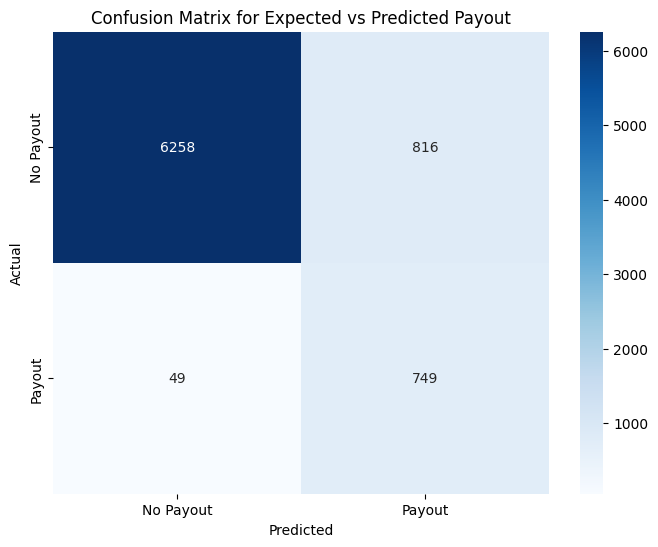

In [536]:
# ----------------------  Test 1 - Gradient Boosted Trees Classifier ------------------------------------

# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

model_name = 'Gradient Boosting Classifier'


# Define model and train using Train data only
GB_model = GradientBoostingClassifier()

# Train model
GB_model.fit(X_train,y_train)

# Use trained model to predict Y for validation
y_pred = GB_model.predict(X_test)



# Evaluate Model using R^2, MSE, and graphs
print_class_scores(y_pred= y_pred,
             y_true= y_test,
             model= model_name
             )


GB_scores = get_class_scores(y_pred= y_pred,
                           y_true= y_test
                           )

cm = confusion_matrix(y_test, y_pred)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Payout', 'Payout'], yticklabels=['No Payout', 'Payout'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Expected vs Predicted Payout")
plt.show()


c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Classifier F1 Score = 0.6085225009956192
Neural Network Classifier Precision Recall-AUC Score = 0.4313177172228051


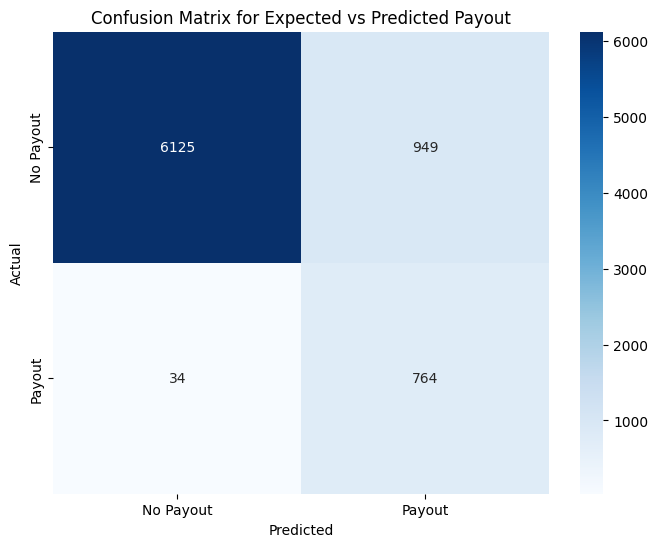

In [537]:
# ----------------------  Test 2 - Multilevel Perceptron Classifier (Neural Networks) ------------------------------------

# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

model_name = 'Neural Network Classifier'


# Define model and train using Train data only
NN_model = MLPClassifier()


# Train model
NN_model.fit(X_train,y_train)

# Use trained model to predict Y for validation
y_pred = NN_model.predict(X_test)



# Evaluate Model using R^2, MSE, and graphs
print_class_scores(y_pred= y_pred,
             y_true= y_test,
             model= model_name
             )

NN_scores = get_class_scores(y_pred= y_pred,
                           y_true= y_test
                           )

cm = confusion_matrix(y_test, y_pred)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Payout', 'Payout'], yticklabels=['No Payout', 'Payout'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Expected vs Predicted Payout")
plt.show()


c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Classifier F1 Score = 0.6734279918864098
Random Forest Classifier Precision Recall-AUC Score = 0.4876367130326335


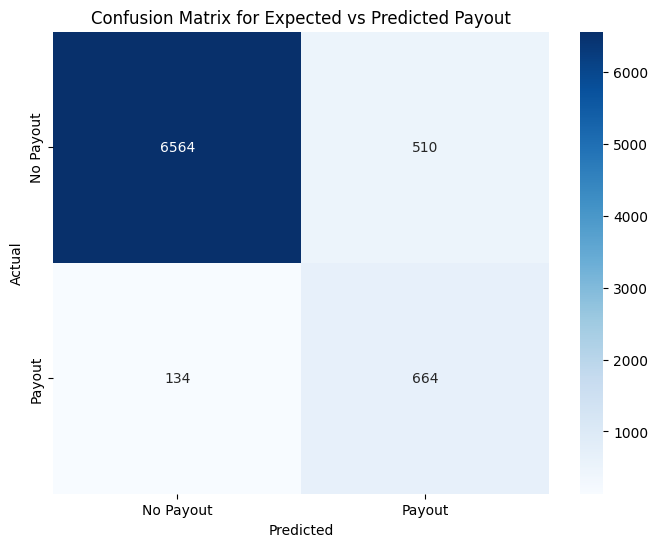

In [538]:
# ----------------------  Test 3 - Random Forest Classifier ------------------------------------

# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

model_name = 'Random Forest Classifier'


# Define model and train using Train data only
RF_model = RandomForestClassifier()


# Train model
RF_model.fit(X_train,y_train)

# Use trained model to predict Y for validation
y_pred = RF_model.predict(X_test)



# Evaluate Model using R^2, MSE, and graphs
print_class_scores(y_pred= y_pred,
             y_true= y_test,
             model= model_name
             )


RFR_scores = get_class_scores(y_pred= y_pred,
                           y_true= y_test
                           )

cm = confusion_matrix(y_test, y_pred)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Payout', 'Payout'], yticklabels=['No Payout', 'Payout'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Expected vs Predicted Payout")
plt.show()


c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Ada Boost Classifier F1 Score = 0.6090799517878666
Ada Boost Classifier Precision Recall-AUC Score = 0.4308678250775429


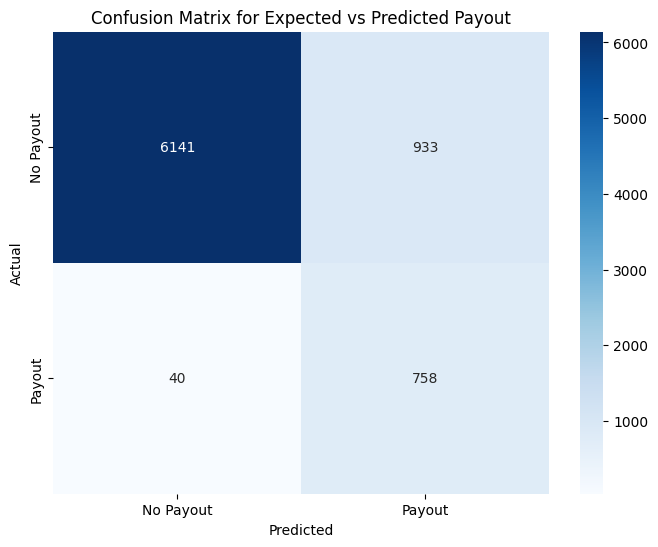

In [539]:
# ----------------------  Test 4 - Ada Boost Classifier ------------------------------------

from sklearn.ensemble import AdaBoostClassifier

# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

model_name = 'Ada Boost Classifier'


# Define model and train using Train data only
AB_model = AdaBoostClassifier()


# Train model
AB_model.fit(X_train,y_train)

# Use trained model to predict Y for validation
y_pred = AB_model.predict(X_test)



# Evaluate Model using R^2, MSE, and graphs
print_class_scores(y_pred= y_pred,
             y_true= y_test,
             model= model_name
             )


AB_scores = get_class_scores(y_pred= y_pred,
                           y_true= y_test
                           )

cm = confusion_matrix(y_test, y_pred)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Payout', 'Payout'], yticklabels=['No Payout', 'Payout'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Expected vs Predicted Payout")
plt.show()


XGBoost Classifier F1 Score = 0.6719914802981896
XGBoost Classifier Precision Recall-AUC Score = 0.48320389529605406


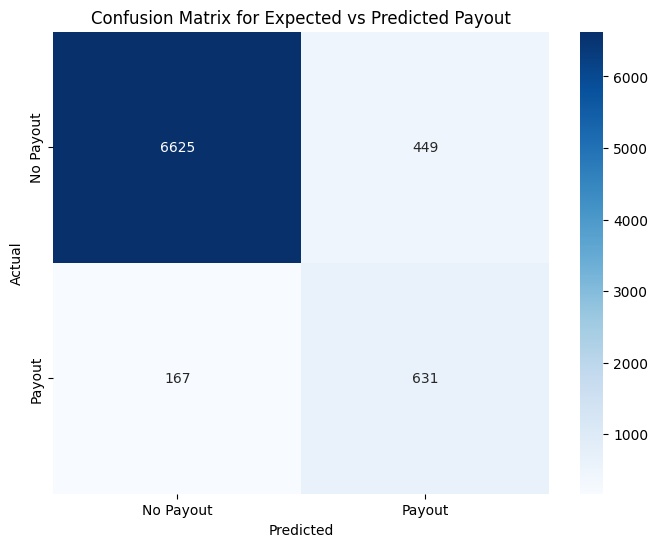

In [540]:
# ----------------------  Test 5 - XGBoost Classifier ------------------------------------

from xgboost import XGBClassifier
# Shortcut to minimize typing - Uncomment depending on 2015 Normal or Comp

model_name = 'XGBoost Classifier'


# Define model and train using Train data only
XGB_model = XGBClassifier()


# Train model
XGB_model.fit(X_train,y_train)

# Use trained model to predict Y for validation
y_pred = XGB_model.predict(X_test)



# Evaluate Model using R^2, MSE, and graphs
print_class_scores(y_pred= y_pred,
             y_true= y_test,
             model= model_name
             )


XGB_scores = get_class_scores(y_pred= y_pred,
                           y_true= y_test
                           )

cm = confusion_matrix(y_test, y_pred)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Payout', 'Payout'], yticklabels=['No Payout', 'Payout'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Expected vs Predicted Payout")
plt.show()


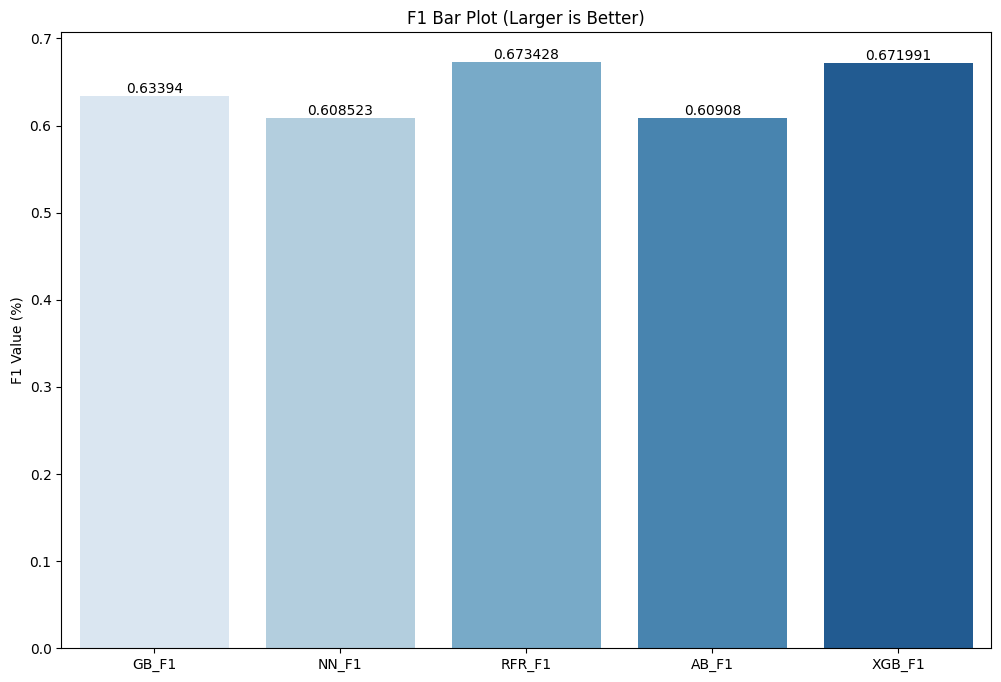

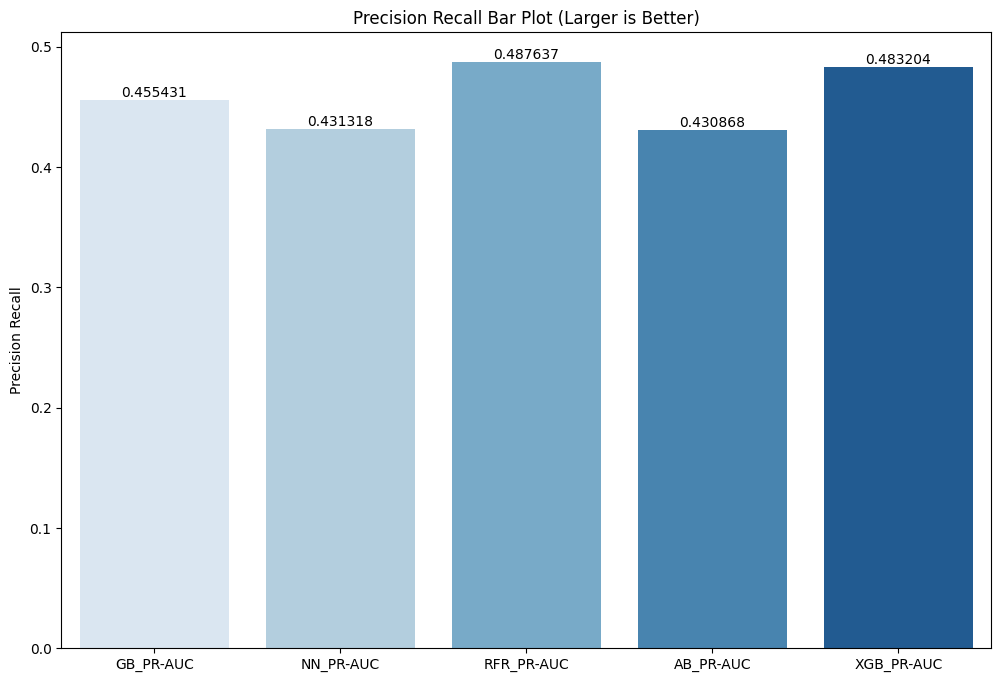

In [541]:
# -------------------------------------------- Quantitative Model Evaluation ---------------------------------------

# Join all F1 values into one list
F1_dict = {
'GB_F1' :GB_scores['F1'],
'NN_F1' :NN_scores['F1'],
'RFR_F1' :RFR_scores['F1'],
'AB_F1' :AB_scores['F1'],
'XGB_F1' :XGB_scores['F1']
}

# Join all PR-AUC values into one list
PR_dict = {
'GB_PR-AUC' :GB_scores['PR-AUC'],
'NN_PR-AUC' :NN_scores['PR-AUC'],
'RFR_PR-AUC' :RFR_scores['PR-AUC'],
'AB_PR-AUC' :AB_scores['PR-AUC'],
'XGB_PR-AUC' :XGB_scores['PR-AUC']
}



# Convert to Dataframe
combined_F1 = pd.DataFrame(F1_dict,index=[0])


# Scaled data by log10 to be more usable for graphs
combined_PR = pd.DataFrame(PR_dict,index=[0]).transpose()




# Plot R2 values
plt.figure(figsize=(12,8))
ax = sns.barplot(data=combined_F1,palette='Blues')

for i in ax.containers:
    ax.bar_label(i, fontsize = 10)

plt.title('F1 Bar Plot (Larger is Better)')
plt.ylabel('F1 Value (%)')
plt.show()


# Plot MSE values
plt.figure(figsize=(12,8))
ax = sns.barplot(data=combined_PR.transpose(),palette='Blues')

for i in ax.containers:
    ax.bar_label(i, fontsize = 10)

plt.title('Precision Recall Bar Plot (Larger is Better)')
plt.ylabel('Precision Recall')
plt.show()


XGBoost - Average F1 Score: 0.91 ± 0.04


c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: T

AdaBoost - Average F1 Score: 0.92 ± 0.03


c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConvers

Random Forest - Average F1 Score: 0.92 ± 0.02


c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.p

Gradient Boosting - Average F1 Score: 0.92 ± 0.02


c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\oakle\AppData\Local\Programs\Python\Pyth

MLP Classifier - Average F1 Score: 0.91 ± 0.02


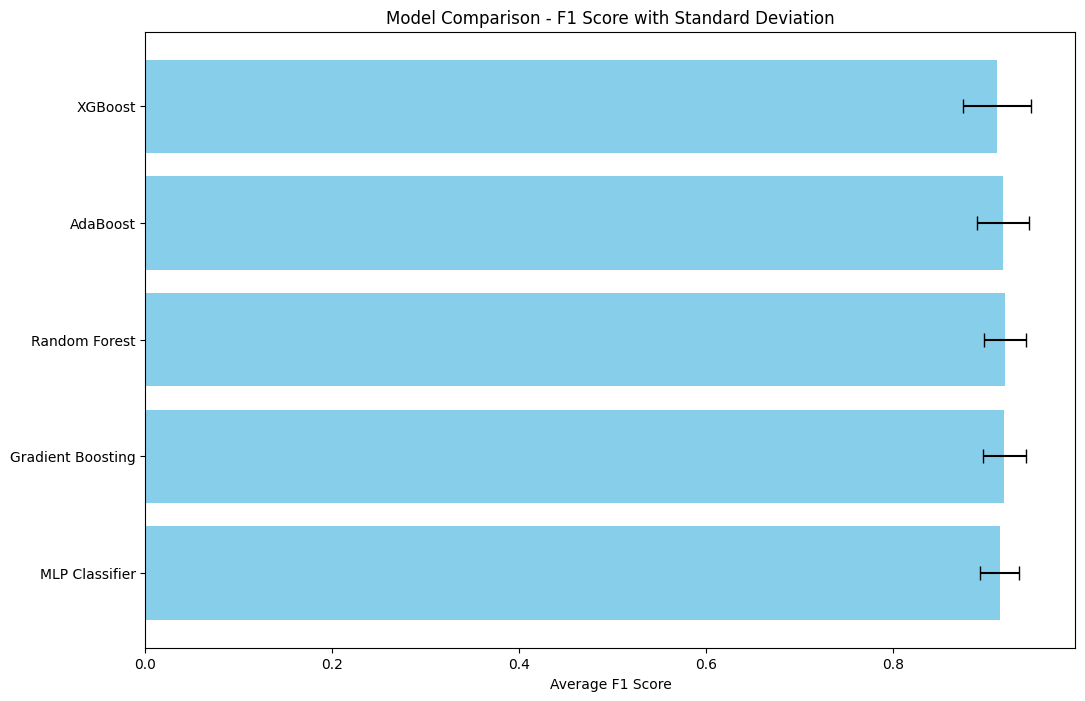

In [542]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Define models to test
models = {
    # 'Logistic Regression': LogisticRegression(),
    # 'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(),
    # 'K-Nearest Neighbors': KNeighborsClassifier(),
    # 'Extra Trees': ExtraTreesClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    # 'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP Classifier': MLPClassifier(max_iter=500)
}

# Store results
model_names = []
f1_means = []
f1_stds = []

# Evaluate each model and collect F1 scores
for name, model in models.items():
    f1_scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=5)
    model_names.append(name)
    f1_means.append(f1_scores.mean())
    f1_stds.append(f1_scores.std())
    print(f"{name} - Average F1 Score: {f1_scores.mean():.2f} ± {f1_scores.std():.2f}")

# Plot F1 scores with standard deviation as error bars
plt.figure(figsize=(12, 8))
plt.barh(model_names, f1_means, xerr=f1_stds, color='skyblue', capsize=5)
plt.xlabel('Average F1 Score')
plt.title('Model Comparison - F1 Score with Standard Deviation')
plt.gca().invert_yaxis()  # Flip y-axis for better readability
plt.show()


In [543]:
# XGBoost was chosen based on computational effieciency and accuracy

# Perform a Grid Seach Cross Validation on XGBoost Classifier
from sklearn.model_selection import GridSearchCV
XGB_model = XGBClassifier()

params = {
    'learning_rate': [0.3, 0.1, 0.05],
    'n_estimators': [20, 35, 50],
}

# grid search
XGB_CV_model = GridSearchCV(
    XGB_model, 
    param_grid=params, 
    cv=10,
)

XGB_CV_model.fit(X_train, y_train)  

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.3, 0.1, 0.05],
                         'n_estimators': [20, 35, 50]})

In [544]:
print(XGB_CV_model.best_params_)

{'learning_rate': 0.3, 'n_estimators': 35}


In [545]:
print(
    f'Memorization performance: {XGB_CV_model.score(X_train, y_train)}\n'
    f'Generalization performance: {XGB_CV_model.score(X_test, y_test)}'
)

Memorization performance: 0.9675872093023256
Generalization performance: 0.9120934959349594


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

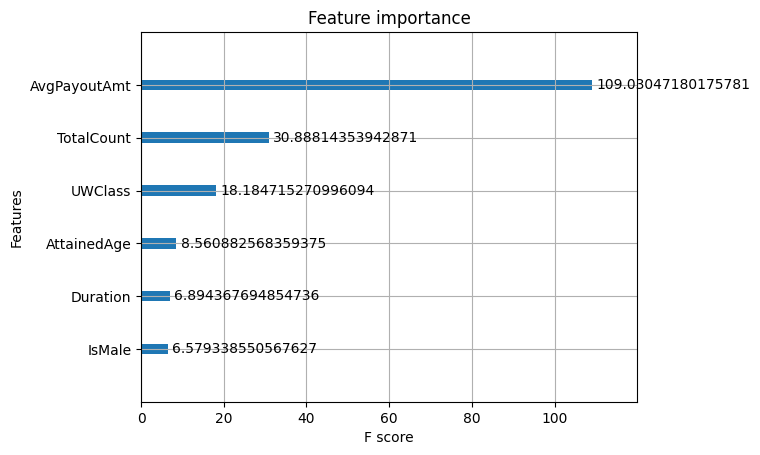

In [546]:
from xgboost import plot_importance
plot_importance(XGB_CV_model.best_estimator_, importance_type='gain')

In [ ]:
# --------------- Final Regression Process-----------

In [550]:
regression_df

,Duration,AttainedAge,UWClass,2015vbtExpAmt,2015vbtExpNum,MortExposureAmt,MortDecAmt,PayoutOccurred,IsMale
0,19,7,1,46.410320,0.0018,50446.00000,0.0,0,1
1,2,3,1,36.750000,0.0012,75000.00000,0.0,0,1
2,1,5,1,12.800000,0.0002,80000.00000,0.0,0,1
3,11,7,7,327.500000,0.0013,250000.00000,0.0,0,1
4,15,NaN,5,687.012931,0.0256,26752.84000,0.0,0,1
...,...,...,...,...,...,...,...,...,...
509290,5,11,2,181.820595,0.0017,102723.50000,0.0,0,1
509291,10,7,5,21.271153,0.0008,23120.81836,0.0,0,0
509292,32,10,3,49.757314,0.0038,25648.10000,0.0,0,0
509293,13,5,1,44.562514,0.0008,51221.28000,0.0,0,1


In [ ]:
# Split, Aggregate, Balance, and Normalize data the same way as classification data



# Aggregate train data
aggregated_df = regression_df.groupby(['IsMale', 
                                       'UWClass', 
                                    #    'CvgIssueAge', 
                                       'AttainedAge', 
                                       'Duration',
                                    #    '2015vbtExpNum'
                                       ]).agg(
    
    TotalCount=('PayoutOccurred', 'count'),
    AvgPayoutAmt=('MortExposureAmt', 'mean'),
    # AvgDeathRisk=('MortExposureNum', 'mean'),
    AvgExpDeathRisk=('2015vbtExpNum','mean'),
    PayoutOccurrenceRate=('PayoutOccurred', 'mean')
).reset_index()

# Aggregate test data
aggregated_test = regression_df.groupby(['IsMale', 
                                     'UWClass', 
                                    #  'CvgIssueAge', 
                                     'AttainedAge', 
                                     'Duration',
                                    #  '2015vbtExpNum'
                                     ]).agg(
    TotalCount=('PayoutOccurred', 'count'),
    AvgPayoutAmt=('MortExposureAmt', 'mean'),
    # AvgDeathRisk=('MortExposureNum', 'mean'),
    AvgExpDeathRisk=('2015vbtExpNum','mean'),
    PayoutOccurrenceRate=('PayoutOccurred', 'mean')
).reset_index()

# Fill nan values with 0
aggregated_train = aggregated_train.fillna(0)
aggregated_test = aggregated_test.fillna(0)


aggregated_train = minmax_scale(X=aggregated_train)
aggregated_train = pd.DataFrame(aggregated_train)

new_column_names = ['IsMale', 'UWClass', 'AttainedAge', 'Duration', '2015vbtExpNum',
                    'TotalCount', 'AvgPayoutAmt', 'PayoutOccurrenceRate']
aggregated_train.columns = new_column_names


# Scale all continuous variables to be between 0-1
aggregated_test = minmax_scale(X=aggregated_test)
aggregated_test = pd.DataFrame(aggregated_test)

new_column_names = ['IsMale', 'UWClass', 'AttainedAge', 'Duration', '2015vbtExpNum',
                    'TotalCount', 'AvgPayoutAmt', 'PayoutOccurrenceRate']

aggregated_test.columns = new_column_names

In [548]:
# Define input and output variables Train

X_train = aggregated_train[['IsMale', 
                   'UWClass', 
                  #  'CvgIssueAge', 
                   'AttainedAge', 
                   'Duration',
                   'TotalCount',
                   'AvgPayoutAmt',
                  #  'AvgDeathRisk',  
                  #  'AvgExpDeathRisk'
                #    'PayoutOccurrenceRate'
                   ]]

# Binary target: 1 if there was a payout, 0 otherwise
y_train= (aggregated_train['PayoutOccurrenceRate'] > 0).astype(int)  


# Define input and output variables Test
X_test = aggregated_test[['IsMale', 
                   'UWClass', 
                  #  'CvgIssueAge', 
                   'AttainedAge', 
                   'Duration',
                   'TotalCount',
                   'AvgPayoutAmt',
                  #  'AvgDeathRisk',
                  #  'AvgExpDeathRisk'
                  #  'PayoutOccurrenceRate'
                   ]]

y_test= (aggregated_test['PayoutOccurrenceRate'] > 0).astype(int)  # Binary target: 1 if there was a payout, 0 otherwise

In [549]:
# Apply SMOTE to the training set only to avoid data leakage
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Checking the distribution after SMOTE
print("After SMOTE:")
print(f'Y_train Value Counts: {y_train_resampled.value_counts()}')
print()
print(f'Training data payout ratio: {y_train_resampled.value_counts()[0]/y_train_resampled.value_counts()[1]}')

X_train= X_train_resampled
y_train= y_train_resampled
X_train

After SMOTE:
Y_train Value Counts: PayoutOccurrenceRate
0    6880
1    6880
Name: count, dtype: int64

Training data payout ratio: 1.0


,IsMale,UWClass,AttainedAge,Duration,TotalCount,AvgPayoutAmt
0,0.0,0.000000,0.000000,0.000000,0.288517,0.120654
1,0.0,0.000000,0.000000,0.025000,0.262436,0.045475
2,0.0,0.000000,0.000000,0.050000,0.316131,0.000000
3,0.0,0.000000,0.000000,0.075000,0.342032,0.000000
4,0.0,0.000000,0.000000,0.100000,0.442078,0.000000
...,...,...,...,...,...,...
13755,0.0,0.285714,0.514489,0.725000,0.068700,0.135516
13756,1.0,0.000000,0.698478,0.050000,0.594009,0.067740
13757,0.0,0.000000,0.818182,0.168744,0.162643,0.100263
13758,1.0,0.714286,0.830568,0.857968,0.049757,0.447943


In [295]:
y_pred = XGB_CV_model.predict(X_test)

y_pred

array([0, 1, 1, ..., 0, 0, 0])

##

##

## --------------------------- FINAL CONDENSED CODE ------------------------------

## Step 1.a: Data Importing and Preprocessing

In [726]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, minmax_scale, Normalizer
import math
import seaborn as sns

from xgboost import XGBClassifier,XGBRegressor
from scipy import stats
from sklearn.metrics import mean_squared_error,mean_absolute_error,f1_score,precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb


Import Data

In [727]:
# Path for PC --- Uncomment out depending on device
# df0 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2020.csv')
# df1 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2021.csv')
# df2 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2022.csv')
# df3 = pd.read_csv(r'C:\Users\oakle\OneDrive\Documents\Code\Mortality\Mortality\Mort2023.csv')


# Path for Laptop
df0 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2020.csv')
df1 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2021.csv')
df2 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2022.csv')
df3 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2023.csv')


data = pd.concat([df0,df1,df2,df3], axis=0,ignore_index=True,)


C:\Users\oakle\AppData\Local\Temp\ipykernel_24544\1008978071.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2020.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_24544\1008978071.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2021.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_24544\1008978071.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2022.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_24544\1008978071.py:12: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv(r'C:\Users\oakle\Documents\

Data Preprocessing

In [728]:


# Define X variable
df = data[['CvgSexCode',
        # 'CvgIssueAge',
        'Duration',
        'AttainedAge',
        'UWClass',
        'SubstandardIndicator',
        '2015vbtExpAmt',
        '2015vbtExpNum',
        '2015vbtCompositeExpAmt',
        '2015vbtCompositeExpNum',
        'MortExposureAmt',
        'MortExposureNum',
        'MortDecAmt'
        ]]

# Remove duplicates
df = df.drop_duplicates()

# Remove Empty Values
df = df.dropna()

df = df[df['SubstandardIndicator'] == 'N']

# Create a 'PayoutOccurred' binary column (1 for payout, 0 for no payout)
df['PayoutOccurred'] = (df['MortDecAmt'] > 0 ).astype(int)

df.reset_index(inplace=True,drop=True)

# Convert sex code to binary
df['IsMale'] = np.where(df['CvgSexCode'] == 'M', 1, 0)

# Convert UnderWritingClass to numeric classes
UWClass_dummies = pd.get_dummies(data=df['UWClass'],dtype=int)
UWClass_dummies

# Remove old columns that have been converted to binary values or removed
df = df.drop(columns=['CvgSexCode','SubstandardIndicator','UWClass'])
df = pd.concat([df,UWClass_dummies],axis =1)


# Group age into groups of 5
# Define the age intervals
bins = [20,25,30,35,40,45,50,55,60,65,70,110] # Up to 70+ group

# Create group labels, assigning the highest group number to the 60+ group
num_groups = len(bins) - 1
labels = list(range(num_groups))

# Categorize ages using pd.cut
df['AttainedAge'] = pd.cut(df['AttainedAge'], bins=bins, labels=labels, right=False)
df = df.fillna(0)
df['AttainedAge'] = df['AttainedAge'].astype(int)

df['Duration'] = pd.qcut(df['Duration'],
                         q=20,
                         labels=range(0,20))
df['Duration'] = df['Duration'].astype(int)


df = df.reindex(['IsMale','Duration','AttainedAge','MortExposureAmt','MortExposureNum','2015vbtExpAmt','2015vbtExpNum','2015vbtCompositeExpAmt','2015vbtCompositeExpNum','PN','PP','PS','PT','SN','SP','SS','ST','MortDecAmt','PayoutOccurred'],axis =1)

# Initial train-test split
train_data, test_data = train_test_split(df, test_size=0.4, random_state=42,stratify=df['PayoutOccurred'])

train_data

,IsMale,Duration,AttainedAge,MortExposureAmt,MortExposureNum,2015vbtExpAmt,2015vbtExpNum,2015vbtCompositeExpAmt,2015vbtCompositeExpNum,PN,PP,PS,PT,SN,SP,SS,ST,MortDecAmt,PayoutOccurred
582418,0,7,3,25177.15,1.0,9.063774,0.0003,11.077946,0.0004,0,0,0,0,1,0,0,0,0.0,0
659817,1,14,5,113167.66,4.0,218.413584,0.0076,218.413584,0.0076,0,0,0,0,0,0,1,0,0.0,0
1662488,1,7,6,750000.00,0.0,982.500000,0.0000,1470.000000,0.0000,1,0,0,0,0,0,0,0,0.0,0
695513,1,4,0,50203.46,1.0,8.032554,0.0001,8.032554,0.0001,0,0,0,0,1,0,0,0,0.0,0
847955,1,14,6,475000.00,0.0,1002.250000,0.0000,1387.000000,0.0000,0,0,0,0,1,0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776842,0,13,6,400000.00,4.0,528.000000,0.0052,708.000000,0.0068,0,0,0,0,1,0,0,0,0.0,0
688798,0,6,3,46045.75,1.0,46.045750,0.0010,24.864705,0.0005,0,0,0,0,0,0,0,1,0.0,0
1442900,0,11,9,25952.42,1.0,109.259688,0.0042,168.690730,0.0065,1,0,0,0,0,0,0,0,0.0,0
258184,1,7,0,226951.19,7.0,18.156095,0.0000,18.156095,0.0000,0,0,0,0,1,0,0,0,0.0,0


## Step 1.b: Data Aggregation and Feature Engineering

In [729]:
# Step 2: Aggregation Function
def aggregate_data(df):

    grouped = df.groupby(['IsMale', 'Duration', 'AttainedAge', 'PN', 'PP', 'PS', 'PT', 'SN', 'SP', 'SS', 'ST']).agg(
        AvgPolicyAmt=('MortExposureAmt', 'mean'),
        AvgExpAmt=('2015vbtExpAmt','mean'),
        AvgExpNum=('2015vbtExpNum','mean'),
        AvgPayoutAmt=('MortDecAmt','mean'),
        PayoutOccurrenceRate=('PayoutOccurred', 'mean')
    ).reset_index().fillna(0)
    return grouped

# Aggregating train and test sets separately
train_agg = aggregate_data(train_data)
test_agg = aggregate_data(test_data)

columns = train_agg.columns

# Normalize data between 0-1
train_agg = pd.DataFrame(Normalizer().fit_transform(train_agg),columns = columns)
test_agg = pd.DataFrame(Normalizer().fit_transform(test_agg),columns = columns)

In [730]:
train_agg

,IsMale,Duration,AttainedAge,PN,PP,PS,PT,SN,SP,SS,ST,AvgPolicyAmt,AvgExpAmt,AvgExpNum,AvgPayoutAmt,PayoutOccurrenceRate
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000007,1.000000,0.000211,9.578232e-10,0.000000,0.000000e+00
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000138,0.000000,1.000000,0.000190,0.000000e+00,0.000000,0.000000e+00
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,1.000000,0.000174,3.342604e-10,0.000000,0.000000e+00
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,1.000000,0.000141,1.163285e-09,0.000048,1.283625e-09
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000009,0.000000,0.000000,0.000000,0.000000,1.000000,0.000212,9.964722e-10,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,0.000008,0.000157,0.000074,0.0,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.999960,0.008964,4.766434e-08,0.000000,0.000000e+00
2395,0.000006,0.000114,0.000054,0.0,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999890,0.011799,1.649012e-07,0.008973,1.490551e-07
2396,0.000016,0.000302,0.000159,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000016,0.000000,0.997405,0.040442,1.105529e-06,0.059569,1.520364e-06
2397,0.000008,0.000148,0.000078,0.0,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.999743,0.022668,1.439097e-07,0.000000,0.000000e+00


In [731]:
# Create Classification Labels for Train/Test after Aggregation
y_class_train = (train_agg['PayoutOccurrenceRate'] > 0).astype(int)
y_class_test = (test_agg['PayoutOccurrenceRate'] > 0).astype(int) 


X_train_agg = train_agg.drop('PayoutOccurrenceRate',axis=1)
X_test_agg = test_agg.drop('PayoutOccurrenceRate',axis=1)

# Print ratio of payout to non-payout
print(y_class_train.value_counts())
train_ratio = (y_class_train.value_counts()[0])/(y_class_train.value_counts()[1])
print(f'Test payout rate: {train_ratio}')
print()


test_ratio = (y_class_test.value_counts()[0])/(y_class_test.value_counts()[1])
print(y_class_test.value_counts())
print(f'Test payout rate: {test_ratio}')

PayoutOccurrenceRate
0    1245
1    1154
Name: count, dtype: int64
Test payout rate: 1.0788561525129983

PayoutOccurrenceRate
0    1311
1    1042
Name: count, dtype: int64
Test payout rate: 1.2581573896353166


## Step 1.C: Class balancing with SMOTE (Synthetic Minority Oversampling TEchnique)

In [732]:
# Balancing the Training Data with SMOTE
from imblearn.over_sampling import SMOTE

def apply_smote(X, y):
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res

# Applying SMOTE on the aggregated training data
X_train_smote, y_class_train_smote = apply_smote(X_train_agg, y_class_train)

In [733]:
train_smote_ratio = (y_class_train_smote.value_counts()[0])/(y_class_train_smote.value_counts()[1])
print(y_class_train_smote.value_counts())
print(f'Train payout rate after SMOTE: {train_smote_ratio}')

PayoutOccurrenceRate
0    1245
1    1245
Name: count, dtype: int64
Train payout rate after SMOTE: 1.0


In [734]:
# Final X_train data:
X_train_smote

,IsMale,Duration,AttainedAge,PN,PP,PS,PT,SN,SP,SS,ST,AvgPolicyAmt,AvgExpAmt,AvgExpNum,AvgPayoutAmt
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000007,1.000000,0.000211,9.578232e-10,0.000000
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000138,0.000000,1.000000,0.000190,0.000000e+00,0.000000
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000002,0.000000,0.000000,1.000000,0.000174,3.342604e-10,0.000000
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000004,0.000000,0.000000,0.000000,1.000000,0.000141,1.163285e-09,0.000048
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000009,0.000000,0.000000,0.000000,0.000000,1.000000,0.000212,9.964722e-10,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485,0.000000,0.000041,0.000073,0.0,0.0,0.0,0.000000,0.000007,0.000000,0.000000,0.000003,0.999832,0.002732,3.454646e-08,0.018126
2486,0.000000,0.000271,0.000103,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000013,0.000005,0.999991,0.002084,6.419233e-08,0.003646
2487,0.000000,0.000149,0.000084,0.0,0.0,0.0,0.000000,0.000004,0.000000,0.000000,0.000009,0.999929,0.004012,5.385804e-08,0.011194
2488,0.000011,0.000134,0.000014,0.0,0.0,0.0,0.000000,0.000007,0.000000,0.000003,0.000000,0.999999,0.000854,2.121221e-08,0.001399


## Step 2: Feature Evaluation Using Collinearity Maxtrix

In [735]:
# ------------------------------------------------ Check Collinearity to rule out variables -----------
from sklearn.preprocessing import StandardScaler

# If num > .90 , Column x Row are collinear
X_train_smote= pd.DataFrame(X_train_smote)

# Put Y infront of X variables
Xy_collin = pd.concat([y_class_train_smote, X_train_smote],axis = 1)

# Define collin as standard scaler - [See Sklearn docs for more info]
collin = StandardScaler()

# Fit collin
collin_fit = collin.fit(Xy_collin)

# Convert collin fit back to pd.Dataframe
df_collin = pd.DataFrame(collin_fit.transform(Xy_collin))
df_collin.columns = Xy_collin.columns
df_collin.index = Xy_collin.index

corr_m = df_collin.corr(method='pearson')

corr_m_abs = corr_m.abs()
corr_m_upper = corr_m_abs.where(
    np.triu(np.ones(corr_m_abs.shape), k=1).astype(bool))

corr_m_upper

where_collinear = corr_m_upper > .9
where_collinear.where(
    np.triu(np.ones(where_collinear.shape), k=1).astype(bool)).fillna(0).astype(int)

C:\Users\oakle\AppData\Local\Temp\ipykernel_24544\681476157.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  np.triu(np.ones(where_collinear.shape), k=1).astype(bool)).fillna(0).astype(int)


,PayoutOccurrenceRate,IsMale,Duration,AttainedAge,PN,PP,PS,PT,SN,SP,SS,ST,AvgPolicyAmt,AvgExpAmt,AvgExpNum,AvgPayoutAmt
PayoutOccurrenceRate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
IsMale,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
Duration,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AttainedAge,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
PN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Illustration of XGBRegressor

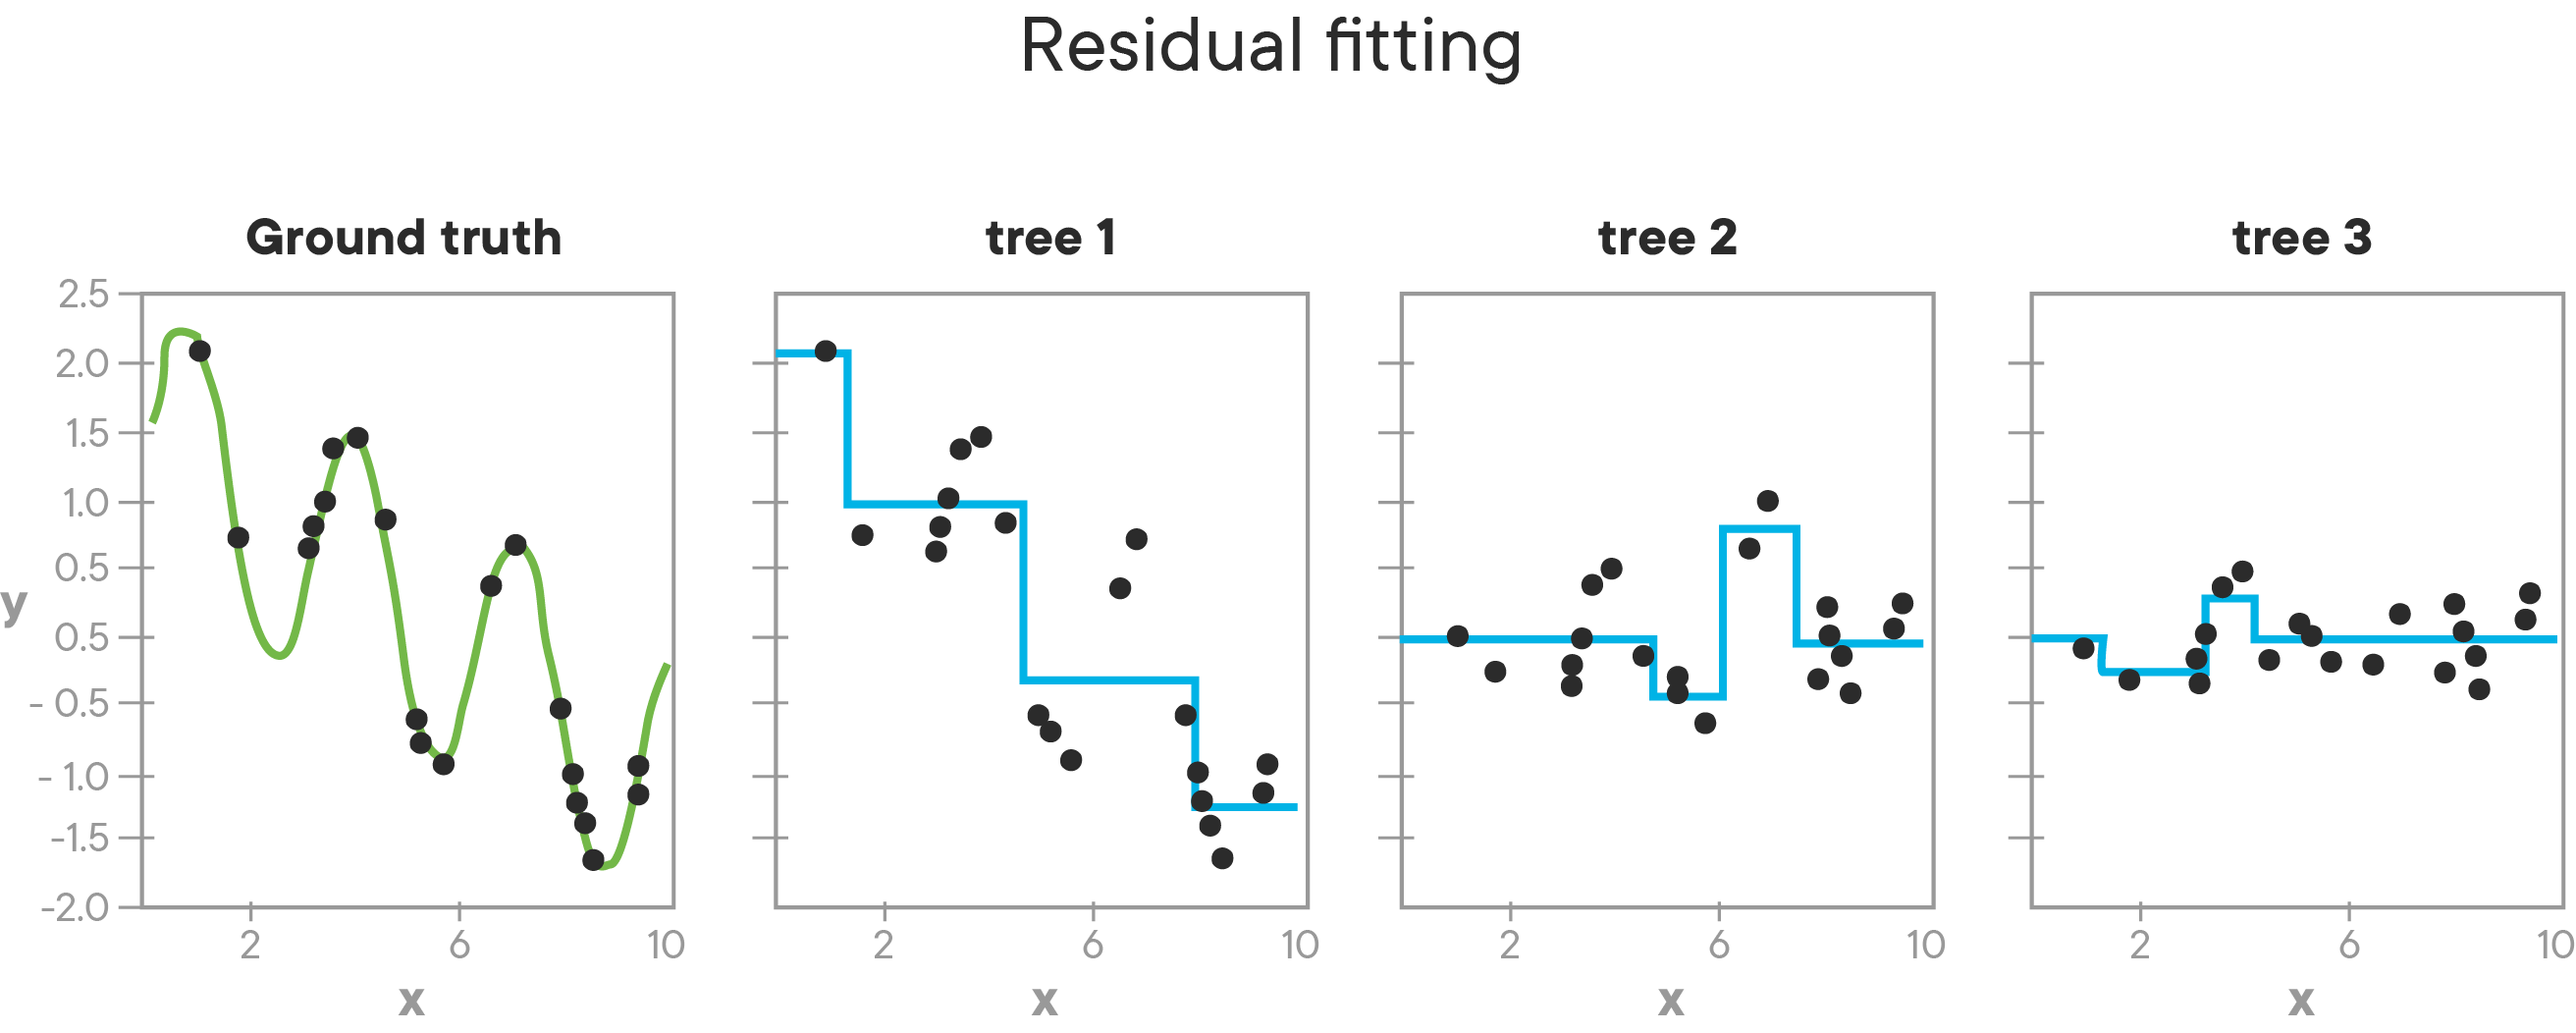

Reference: https://github.com/learn-co-curriculum/dsc-gradient-boosting-and-weak-learners/blob/master/index.ipynb

* Gradient boosting starts with a weak learner that makes predictions on the dataset. The algorithm then checks this learner's performance, identifying examples that it got right and wrong.
* The model then calculates the **residuals** for each data point, to determine how far off the mark each prediction was.
* The model then combines these residuals with a **loss function** to calculate the overall loss. There are many loss functions that are used -- the thing that matters most is that the loss function is **differentiable** so that we can use calculus to compute the **gradient for the loss**, given the inputs of the model.
* We then use the gradients and the loss as predictors to train the next tree. In this way, we can use Gradient Descent to minimize the overall loss.

Since the loss is most heavily inflated by examples where the model was wrong, gradient descent will push the algorithm towards creating a new learner that will focus on these harder examples. If the next tree gets these right, then the loss goes down! In this way, gradient descent allows us to continually train and improve on the loss for each model to improve the overall performance of the ensemble as a whole by focusing on the "hard" examples that cause the loss to be high.

## Step 3: Model Training and Evaluation

In [736]:

# Step 3: Train Classification Model 

from xgboost import XGBClassifier

classifier = XGBClassifier()  # Define Classifier model

#train on non-smote data
classifier.fit(X_train_agg.drop(['AvgPayoutAmt',],axis=1), y_class_train)

# Classification predictions on test set
y_class_pred = classifier.predict(X_test_agg.drop('AvgPayoutAmt',axis=1))
f1 = f1_score(y_class_test, y_class_pred)
print("Classification F1 Score:", f1)

# train on smote data
classifier.fit(X_train_smote.drop('AvgPayoutAmt',axis=1), y_class_train_smote)

# Predict on the test set
y_class_pred = classifier.predict(X_test_agg.drop('AvgPayoutAmt',axis=1))
f1 = f1_score(y_class_test, y_class_pred)
print("Classification F1 Score after SMOTE:", f1)



Classification F1 Score: 0.9348549690917737
Classification F1 Score after SMOTE: 0.937381404174573


## Step 4.a: Classification Model Crossvalidation and Optimization

In [744]:
# ------------- Use Crossvalidation to train better model ------------

# Define params for crossvalidation
params = {
    'learning_rate': [0.3, 0.1, 0.05],
    'max_depth': [3, 4],
    'subsample': [0.8, 0.9],
    'n_estimators': [20, 35, 50],
    'reg_lambda': [0.1, 0.05],
}

class_cv = GridSearchCV(
    classifier,
    param_grid= params,
    cv=10
)

# Train crossvalidation model on smote train data
class_cv.fit(X_train_smote.drop('AvgPayoutAmt',axis=1),y_class_train_smote)

# Print best params
print(class_cv.best_params_)

# Use cross validated model to predict classification
y_class_pred = class_cv.best_estimator_.predict(X_test_agg.drop('AvgPayoutAmt',axis=1))



ValueError: 
All the 720 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1512, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 596, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py", line 1003, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 1573, in __init__
    self._init(
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 1632, in _init
    it.reraise()
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 550, in _handle_exception
    return fn()
           ^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py", line 1388, in next
    input_data(**self.kwargs)
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 617, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py", line 1431, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
                                       ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py", line 611, in _transform_pandas_df
    arrays = pandas_transform_data(data)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py", line 550, in pandas_transform_data
    result.append(oth_type(data[col]))
                  ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py", line 515, in oth_type
    ser.dtype,
    ^^^^^^^^^
  File "c:\Users\oakle\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py", line 6299, in __getattr__
    return object.__getattribute__(self, name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'DataFrame' object has no attribute 'dtype'. Did you mean: 'dtypes'?


## Step 4.b: Classification Model Evaluation

Memorization performance: 0.9815261044176706
Generalization score: 0.932001699957501


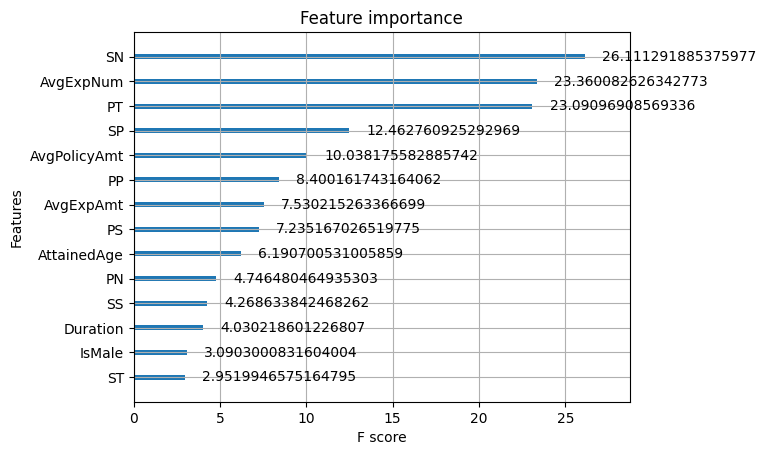

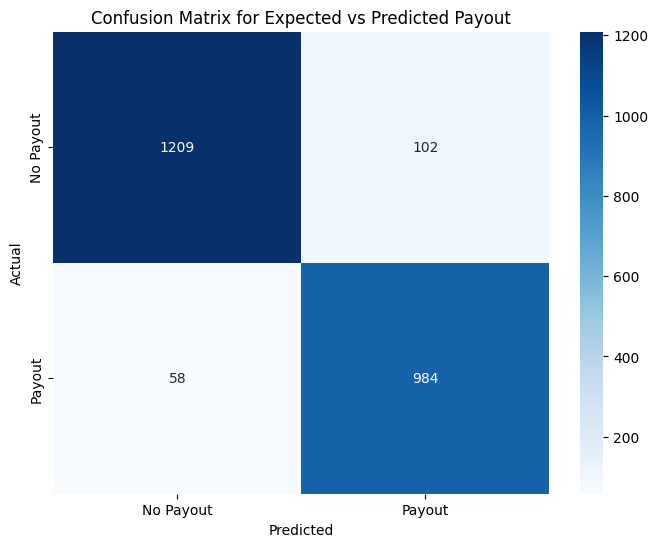

In [ ]:
# Plot the importance of each variable
xgb.plot_importance(class_cv.best_estimator_, importance_type='gain')

# Print evaluation metrics
print(
    f'Memorization performance: {class_cv.score(X_train_smote.drop('AvgPayoutAmt',axis=1), y_class_train_smote)}\n'
    f'Generalization score: {class_cv.score(X_test_agg.drop('AvgPayoutAmt',axis=1), y_class_test)}'
)

# Plot confusion Matrix
cm = confusion_matrix(y_class_test, y_class_pred)

# Step 2: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Payout', 'Payout'], yticklabels=['No Payout', 'Payout'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Expected vs Predicted Payout")
plt.show()


In [ ]:
X_test_agg

,IsMale,Duration,AttainedAge,PN,PP,PS,PT,SN,SP,SS,ST,AvgPolicyAmt,AvgExpAmt,AvgExpNum,AvgPayoutAmt
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000007,1.000000,0.000212,1.108513e-09,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,1.000000,0.000175,3.806896e-10,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,1.000000,0.000141,1.194426e-09,0.000024
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000007,0.000000,0.000000,0.000000,0.000000,1.000000,0.000214,6.491083e-10,0.000000
4,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000172,4.818955e-10,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2348,0.000008,0.000152,0.000072,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.999959,0.009007,5.242539e-08,0.000000
2349,0.000006,0.000111,0.000053,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999867,0.011739,1.676709e-07,0.011292
2350,0.000016,0.000300,0.000158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000016,0.000000,0.997241,0.040522,1.069744e-06,0.062188
2351,0.000007,0.000141,0.000074,0.000000,0.000000,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.978325,0.020599,1.273793e-07,0.206049


In [ ]:
# Regression Model (Only Positive Payouts)
X_train_smote = pd.concat([X_train_smote,y_class_train_smote],axis =1)
X_test_agg = pd.concat([X_test_agg,y_class_test],axis=1)


X_reg_train = X_train_smote[X_train_smote['PayoutOccurrenceRate'] > 0]
y_reg_train = X_reg_train['AvgPayoutAmt']
X_reg_train = X_reg_train.drop(['AvgPayoutAmt','PayoutOccurrenceRate'],axis =1)

X_reg_test = X_test_agg[X_test_agg['PayoutOccurrenceRate'] > 0]
y_reg_test = X_reg_test['AvgPayoutAmt']
X_reg_test = X_reg_test.drop(['AvgPayoutAmt','PayoutOccurrenceRate'],axis =1)

# X_test_agg = X_test_agg.drop('PayoutOccurrenceRate')
# X_train_smote = X_train_smote.drop('PayoutOccurrenceRate')


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
# Train Regression Model
reg = XGBRegressor(objective="reg:squarederror")
reg.fit(X_reg_train, y_reg_train)

# Predict Payout Amounts
y_reg_pred = reg.predict(X_reg_test)
mae = mean_absolute_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test,y_reg_pred)
print("Regression MAE:", mae)
print("Regression R2:",r2)


Regression MAE: 0.0014413808364683053
Regression R2: 0.9239205917761998


In [ ]:
# Combining Classification and Regression Results
final_predictions = []
for i, pred in enumerate(y_class_pred):
    if pred == 0:
        final_predictions.append(0)  # No payout
    else:
        # If payout is predicted, use the regression model's estimate
        final_predictions.append(y_reg_pred[i] if i < len(y_reg_pred) else 0)



In [745]:
# Final Evaluation
final_mse = mean_squared_error(y_reg_test, final_predictions)
print("Combined Model Final MSE:", final_mse)

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_class_test, classifier.predict_proba(X_test_agg.drop(columns=['PayoutOccurrenceRate', 'AvgPayoutAmt']))[:, 1])

plt.plot(recall, precision, marker='.', label='Binary Classification PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve after SMOTE')
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [1042, 2353]